# Softmax(Application)

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 1 Load Data set

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('The x_train shape is: {}'.format(x_train.shape))
print('The y_test shape is: {}'.format(y_train.shape))

The x_train shape is: (60000, 28, 28)
The y_test shape is: (60000,)


来查看一下原始图片:

 The digits is: 5


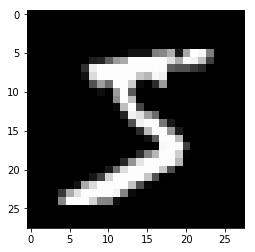

In [4]:
index = 0
plt.imshow(x_train[0],cmap='gray')
print('\033[0;31m The digits is: {}\033[0m'.format(y_train[index]))
plt.show()

## 2-1 Using One Hot encodings

在使用softmax的时候我们需要注意的一点就是需要将$labels$转换为一个"Hot"形式的向量,因为我们的网络输出的结构是(n_sample,C)或者(C,n_sample),这里的n_sample为样本个数.

在深度学习的许多时候,我们需要将$labels$向量转换为一个范围是0到$C-1$的形式,其中这里的$C$是分类的个数,比如$C=4$,那么我们就需要将其转换成下面这种形式.
![](../../../picture/122.png)

也就是$labels$的元素在对应的"Hot"矩阵中为1,比如按照上面的方式而言对于第一个样本$y=1$,那么第一列的索引为1的位置上就是1.

另外在我们的网络经过softmax activation function之后,也会形成类似于上述的"Hot"矩阵,比如可能产生这样的结果:

$predict\;y=\begin{bmatrix}
0.842& 0.5 & 0.03 & 0.8 & 0.1 &0.2\\ 
0.042& 0.4 & 0.07 & 0.1 & 0.1 & 0.4\\
0.002& 0.05 & 0.4 & 0.05 & 0.7 & 0.2\\
0.114& 0.05 & 0.5 &0.05 & 0.1 & 0.2\\
\end{bmatrix}$

然后我们可以取每一列中概率最大的(因为我们这里是(C,n_sample)的形式),所以返回的索引结果是[0,0,3,0,2,1]

这样就正好应对我们的真实标签$y$,进而就可以计算正确率或错误率.

**Note:**softmax矩阵所有的类概率之和为1,比如在这个例子中每一列的概率之和要为1,这是非常重要的可以用于检验代码是否正确.

那么我们在Numpy中可以使用以下代码将$labels$转换成"Hot"形式.
- np.eye()

In [5]:
def One_hot(Y,classes):
    '''
    Implement y to "hot y"
    Parameters:
    ----------
        1.Y labels of data set
        2.classes  Number of classes
    Return:
    ------
        hot_matrix
        
    Expansion:
    ---------
        np.eye(classes)[Y.ravel()].T equals
        a = np.eye(classes)
        a = a[:,Y.ravel()]
        
        ------------------
        b = np.array([1,2,3,4])
        print(b[[3,3,3,0]])
        print(b)
        
        [4 4 4 1]
        [1 2 3 4]
        
        ------------------
        c = np.eye(4)
        print(c)
        y = [3,3,0,2]
        c[:,y]
        
        [[1. 0. 0. 0.]
         [0. 1. 0. 0.]
         [0. 0. 1. 0.]
         [0. 0. 0. 1.]]
         
array([[0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 1., 0., 0.]])
       
       实际上就是利用原有输入索引位上的元素去新创建一个数组.以b为例子就是
       将原有索引3(值为4) 放在新创建数组的第一位，
       将原有索引3(值为4) 放在新创建数组的第二位,
       将原有索引3(值为4) 放在新创建数组的第三位,
       将原有索引0(值为1) 放在新创建数组的第四位.
       那么c的例子就是保证行数不变的情况下利用索引元素新创建数组.
        
    '''
    # 实际上就是行发生变化，再转置就成了类似于上面的c例子,ravel()这里可有可无,因为我们这里y的形状是1维的,但是如果你的标签是2维的
    # 那么就需要将其展平,可以使用ravel()或者ndarray.flatten()
    
    hot_matrix = np.eye(classes)[Y.ravel()].T 
    return hot_matrix

In [6]:
# classes of y
n_classes = len(np.unique(y_train))
y_train_hot_matrix = One_hot(y_train,n_classes)
print('y_train_hot_matrix: ')
print(y_train_hot_matrix)
print('y_train_hot_matrix shape:')
print(y_train_hot_matrix.shape)
print('y_train matix:')
print(y_train)

y_train_hot_matrix: 
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
y_train_hot_matrix shape:
(10, 60000)
y_train matix:
[5 0 4 ... 5 6 8]


很明显可以看到第二个样本$y_2=0$,那么在"Hot"矩阵中,第二列索引为0的位置为1.

**Note:**

实际上我更倾向于(n_sample,C)的形式,而不是这里的(C,n_sample)的形式,实际上也很简单,两者之间就差一个转置,那么我下面都会采用(n_sample,C)的形式即:(样本个数,标签类个数)的形式.

那么下面我们重新定义上述hot函数记为```ONE_HOT```.

In [7]:
def ONE_HOT(y,n_classes):
    return np.eye(n_classes)[y]

In [8]:
# classes of y
n_classes = len(np.unique(y_train))
y_train_hot_matrix = ONE_HOT(y_train,n_classes)
print('y_train_hot_matrix: ')
print(y_train_hot_matrix)
print('y_train_hot_matrix shape:')
print(y_train_hot_matrix.shape)

y_train_hot_matrix: 
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
y_train_hot_matrix shape:
(60000, 10)


## 2-2 Change shape in "X" data set

接下去我们将training/validation data set转换为我们能够接受的shape,即:(n_sample,features)

In [9]:
x_train = x_train.reshape(x_train.shape[0],-1) / 255
x_test = x_test.reshape(x_test.shape[0],-1) / 255
print('The x_train shape is {}'.format(x_train.shape))
print('The x_test shape is {}'.format(x_test.shape))

The x_train shape is (60000, 784)
The x_test shape is (10000, 784)


所以我们这里使用的样本shape形式总结为:

- $x:$(n_sample,features)

- $y:$(n_sample,C)

## 3. Create Model

### 3-1 Initialization Parameters

我们这里的网络结构选择:linear1(25 units)-->linear2(12 units)-->linear3(10 units)

我们这里的初始化方式选择He:

```He initialization = np.random.randn(input_features,output_features) / np.sqrt(input_features).```

这里的L为: input'units + hidden layers'units

另外我们的Optimizer选择Adam,所以我们还需要初始化Adam Optimizer的参数$m,v$

In [10]:
def initial_parameters(L,layers):
    """
    initialization parameters.
    Arguments:
    ---------
        L: #input'units + hidden layers'units
        layers: hidden layers's units
    Return:
    ------
        parameters: include weights and bias. 
    """
    np.random.seed(1)
    parameters = {}
    V = {}
    M = {}
    for l in range(L-1):
        W = np.random.randn(layers[l],layers[l+1]) / np.sqrt(layers[l])
        b = np.zeros((1,layers[l+1]))
        
        V['V_dW'+str(l+1)] = np.zeros(W.shape)
        V['V_db'+str(l+1)] = np.zeros(b.shape)
        M['M_dW'+str(l+1)] = np.zeros(W.shape)
        M['M_db'+str(l+1)] = np.zeros(b.shape)
        parameters['W'+str(l+1)] = W
        parameters['b'+str(l+1)] = b
        
    return parameters,V,M

In [11]:
layers = [25,12,10]
layers.insert(0,x_train.shape[1])
L = len(layers)
parameters,V,M = initial_parameters(L,layers)
for key,value in parameters.items():
    print(key,'shape is',value.shape)

W1 shape is (784, 25)
b1 shape is (1, 25)
W2 shape is (25, 12)
b2 shape is (1, 12)
W3 shape is (12, 10)
b3 shape is (1, 10)


### 3-2 Forward Propagation

创建向前传播,最后返回出```hat_y```的shape is (n_sample,C).

隐藏层采用ReLu activation function,输出层采用softmax activation function.

**Note:**在某些情况下,采用softmax会出现下溢的情况,这时候往往有两个方法可以选择1.更改weights的初始值.2.使用log的方式

In [12]:
def relu(Z):
    """
    ReLu activation
    """
    return np.maximum(0,Z)

In [13]:
def softmax(Z):
    """
    softmax activation
    """
    t = np.exp(Z)
    return t/np.sum(t,axis=1,keepdims=True)

In [14]:
def forward(X,L,parameters):
    """
    forward propagation
    """
    A = X
    cache = {'A0':X}
    for l in range(L-1):
        W = parameters['W'+str(l+1)]
        b = parameters['b'+str(l+1)]
        Z = np.add(np.dot(A,W),b)
        cache['Z'+str(l+1)] = Z
        if l != L -2 :
            A = relu(Z)
        else:
            A = softmax(Z)
        cache['A'+str(l+1)] = A
    return A,cache

In [15]:
softmax_matrix,cache = forward(x_train,L,parameters)
print('Softmax matrix shape is ',softmax_matrix.shape)
# check softamx
print(softmax_matrix.sum(axis=1))

Softmax matrix shape is  (60000, 10)
[1. 1. 1. ... 1. 1. 1.]


### 3-3 Loss Fucntion

我们使用softmax的损失函数:

$loss = -\frac{1}{m}ylog(A)$

In [16]:
def Loss(A,y):
    """
    caculate loss value in mini-batchs or score data.
    """
    m = y.shape[0]
    loss = - np.sum(np.multiply(y,np.log(A))) / m
    return loss

In [17]:
loss = Loss(softmax_matrix,y_train_hot_matrix)
print('The loss is {}'.format(loss))

The loss is 2.3311101745895173


### 3-4 Backward

softmax的Backward Propagation形式是和Logistics Regression的形式是一样的,更多详细内容查看[Softmax(Theory)](https://github.com/woaij100/Classic_machine_learning/blob/master/4-4%20Softmax(Theory).ipynb)

In [18]:
def backward(A,y,cache,parameters,L):
    """
    Backward propagation
    """
    m = y.shape[0]
    dparameters = {}
    for l in range(L-1,0,-1):
        if l == L-1:
            dZ = A - y
            dW = np.dot(cache['A'+str(l-1)].T,dZ) / m
            db = np.sum(dZ,axis=0,keepdims=True) / m
        else:
            dA = np.dot(dZ,parameters['W'+str(l+1)].T)
            dZ = np.multiply(dA,np.int64(cache['Z'+str(l)]>0))
            A = cache['A'+str(l-1)]
            dW = np.dot(A.T,dZ) /m
            db = np.sum(dZ,axis=0,keepdims=True) / m
        dparameters['dW'+str(l)] = dW
        dparameters['db'+str(l)] = db
    
    return dparameters

In [19]:
dparameters = backward(softmax_matrix,y_train_hot_matrix,cache,parameters,L)
for key, values in dparameters.items():
    print(key,values.shape)

dW3 (12, 10)
db3 (1, 10)
dW2 (25, 12)
db2 (1, 12)
dW1 (784, 25)
db1 (1, 25)


### 3-5 Update

更新参数,我们这里使用Adam的形式

$m_{t}=\beta_{1}m_{t-1}+(1-\beta_{1})g_{t}$

$v_t=\beta_{2}v_{t-1}+(1-\beta_2)g^{2}_t$

$\widehat{m_t}=\frac{m_t}{1-\beta_{1}^{t}}$

$\widehat{v_t}=\frac{v_t}{1-\beta_{2}^{t}}$

$\theta_{t+1}=\theta_{t}-\frac{\eta}{\sqrt{\widehat{v_t}+\epsilon}}\cdot\widehat{m_t}$

建议 $β_1 ＝ 0.9,β_2 ＝ 0.999,ϵ ＝ 1e−8$,$\alpha=0.001$

In [20]:
def Update(L,dparameters,parameters,V,M,beta_1,beta_2,t,lr,epsilon=1e-8):
    """
    Updating parameters and using Adam optimizeer.
    """
    for l in range(L-1):
        M['M_dW'+str(l+1)] = beta_1 * M['M_dW'+str(l+1)] + (1-beta_1) * dparameters['dW'+str(l+1)]
        M['M_db'+str(l+1)] = beta_1 * M['M_db'+str(l+1)] + (1-beta_1) * dparameters['db'+str(l+1)]
        
        V['V_dW'+str(l+1)] = beta_2 * V['V_dW'+str(l+1)] + (1-beta_2) * np.square(dparameters['dW'+str(l+1)])
        V['V_db'+str(l+1)] = beta_2 * V['V_db'+str(l+1)] + (1-beta_2) * np.square(dparameters['db'+str(l+1)])
        
        M_correct_dW = M['M_dW'+str(l+1)]/ (1-np.power(beta_1,t))
        M_correct_db = M['M_db'+str(l+1)]/ (1-np.power(beta_1,t))
        
        V_correect_dW = V['V_dW'+str(l+1)]/ (1-np.power(beta_2,t))
        V_correect_db = V['V_db'+str(l+1)]/ (1-np.power(beta_2,t))
        
        parameters['W'+str(l+1)] -= lr * M_correct_dW /(np.sqrt(V_correect_dW+epsilon)) 
        parameters['b'+str(l+1)] -= lr * M_correct_db /(np.sqrt(V_correect_db+epsilon)) 
    
    return parameters,V,M

In [21]:
beta_1 = 0.9
beta_2 = 0.999
t = 1
lr = 0.001
parameters,V,M = Update(L,dparameters,parameters,V,M,beta_1,beta_2,t,lr)
softmax_matrix,cache = forward(x_train,L,parameters)
loss = Loss(softmax_matrix,y_train_hot_matrix)
print('The loss is {}'.format(loss))

The loss is 2.2874135153867385


### 3-5 Mini-Batchs

现在我们创建Mini-batchs的形式,batch size为64.

这里的y的形状为(n_sample,C)

In [22]:
def random_mini_batchs(X,y,seed,batc_size=64):
    """
    Create mini-batchs.
    """
    np.random.seed(seed) # make sure every epochs the data is shuffle.
    
    m = X.shape[0]
    mini_batchs = []
    
    index_ = np.random.permutation(m)
    
    shuffle_X = X[index_,:]
    shuffle_y = y[index_,:]
    
    num_compute_minibatch_size = m // batc_size
    for i in range(num_compute_minibatch_size):
        mini_x = shuffle_X[i*batc_size:(i+1)*batc_size,:]
    
        mini_y = shuffle_y[i*batc_size:(i+1)*batc_size,:]
        mini_batch = (mini_x,mini_y)
        mini_batchs.append(mini_batch)
        
    if m % batc_size !=0:
        mini_x = shuffle_X[num_compute_minibatch_size * batc_size:,:]
        mini_y = shuffle_y[num_compute_minibatch_size * batc_size:,:]
        mini_batch = (mini_x,mini_y)
        mini_batchs.append(mini_batch)
    
    return mini_batchs

### 3-6 Score Function

创建评分函数,用于计算迭代过程中的training/validation 正确率和validation的loss.

In [23]:
def score(data,labels,L,parameters,is_loss=False):
    """
    score model and return correct rate or loss value.
    """
    m = labels.shape[0]
    A,_ = forward(data,L,parameters)
    predict_y = np.argmax(A,axis=1)
    true_y = np.argmax(labels,axis=1)
    acc = np.equal(true_y,predict_y).sum() / m
    if is_loss:
        loss = Loss(A,labels)
        return acc,loss
    else:
        return acc

### 3-7 Model

到现在为止我们已经做好建立模型前的一切准备,现在可以开始建立模型

In [24]:
def Softmax_Model(layers,data,labels,val_data,val_labels,lr,epochs,beta_1=0.9,beta_2=0.999,batc_size=64):
    
    """
    Implement softmax model.
    NN model:Linear(25)--->Linear(12)--->Linear(10)
    """
    layers.insert(0,data.shape[1])
    L = len(layers)
    n_classes = len(np.unique(labels))
    y_train_hot = ONE_HOT(labels,n_classes)
    y_val_hot = ONE_HOT(val_labels,n_classes)
    seed = 0
    t = 0
    losses = []
    val_losses = []
    acc_trains = []
    acc_vals = []
    
    parameters,V,M = initial_parameters(L,layers)
    
    num_minibatches  = data.shape[1] / batc_size
    
    for epoch in range(epochs):
        epoch_cost = 0
        seed +=1
        mini_batchs = random_mini_batchs(data,y_train_hot,seed=seed,batc_size=batc_size)
        for mini_x,mini_y in mini_batchs:
            t += 1
            A,cache = forward(mini_x,L,parameters)
            dparameters = backward(A,mini_y,cache,parameters,L)
            parameters,V,M = Update(L,dparameters,parameters,V,M,beta_1,beta_2,t,lr)
            
        acc_train,train_loss = score(data,y_train_hot,L,parameters,True)
        acc_val,val_loss = score(val_data,y_val_hot,L,parameters,True)
        
        losses.append(train_loss)
        val_losses.append(val_loss)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        
        print('\033[0;35m [{}/{}] loss:{},acc_train:{},val_loss:{},acc_val:{}\033[0m \r'.format(epoch+1,
                                                                                              epochs,
                                                                                              loss,
                                                                                              acc_train,
                                                                                              val_loss,
                                                                                              acc_val),end="",flush=True)
    return losses,val_losses,acc_trains,acc_vals,parameters
        

In [25]:
layers = [25,12,10]
losses,val_losses,acc_trains,acc_vals,parameters = Softmax_Model(layers,x_train,y_train,x_test,y_test,
                                                      lr=0.001,
                                                      epochs=20,
                                                      beta_1=0.9,
                                                      beta_2=0.999,
                                                      batc_size=64)

## 4 PLot Loss/Accuracy

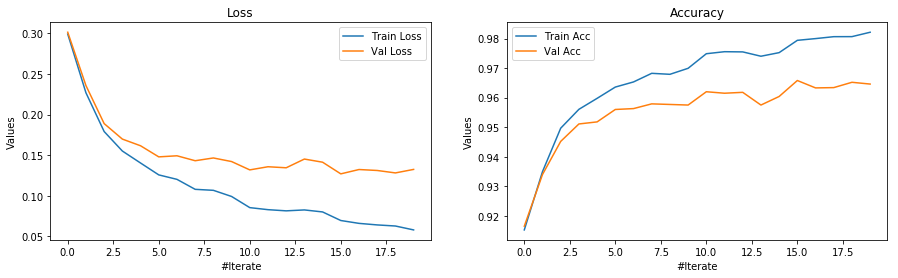

In [26]:
figure = plt.figure(figsize=(15,4))
ax1 = figure.add_subplot(1,2,1)
ax1.plot(losses,label="Train Loss")
ax1.plot(val_losses,label="Val Loss")
ax1.set_title('Loss')
ax1.set_xlabel('#Iterate')
ax1.set_ylabel('Values')
ax1.legend()

ax2 = figure.add_subplot(1,2,2)
ax2.plot(acc_trains,label="Train Acc")
ax2.plot(acc_vals,label="Val Acc")
ax2.set_title('Accuracy')
ax2.set_xlabel('#Iterate')
ax2.set_ylabel('Values')
ax2.legend()

### 5 Test Your Image

crop函数带的参数为(左,上,右,下).

In [27]:
from PIL import Image

加载我们要测试的图片,由于我们训练样本是灰度图,所以我们也需要将图片转换为灰度图.

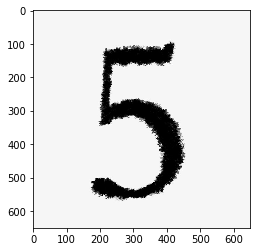

In [28]:
img = Image.open('test.jpg').convert('L') # change to gray
# can choose it to crop image
# img = img.crop((50,90,190,280)) 
plt.imshow(img,cmap='gray')

我们的训练样本大小为(28,28),所以我们也需要将图片转换为(28,28),由于我们的图片比较简单,这里我们就使用线性插值法改变图片大小.

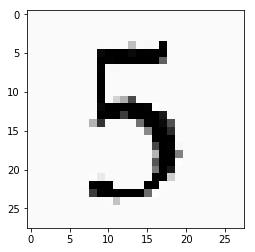

In [29]:
img = img.resize((28,28))
plt.imshow(img,cmap='gray')

转换为data训练的shape(1,784)

In [30]:
data = np.asarray(img).reshape(1,-1) /255
print('The data shape is {}'.format(data.shape))

The data shape is (1, 784)


预测一下:

In [31]:
A,_ = forward(data,L,parameters)
predict = np.argmax(A,axis=1)
print('Predict labels is {}'.format(predict))

Predict labels is [5]


Congratulations!,结果是正确的.当然如果结果错了也是正常现象.